In [1]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [2]:
# constant Heston parameters
kappa = 2
theta = 0.2
v_0 = theta #
rho = 0.6
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [3]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

In [4]:
prices.shape

(10000, 50)

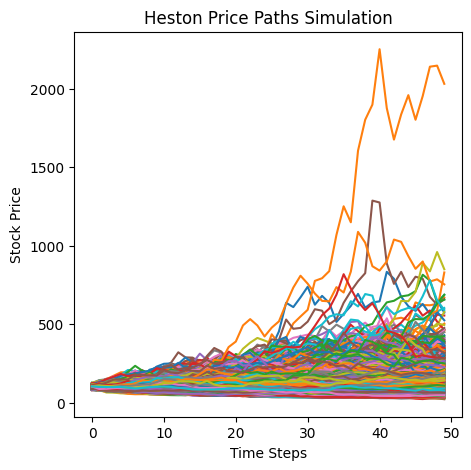

In [5]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


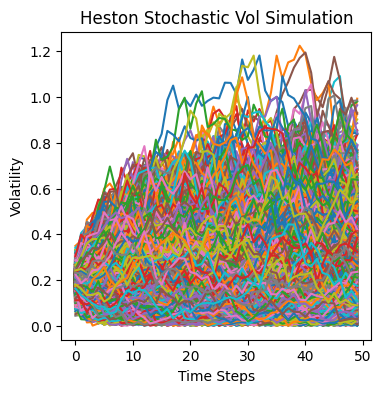

In [6]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [7]:
#############################################################################################

In [7]:
thetas=0.2 #Long run variance θ
kappas= 2 # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [15]:
by_parameter = {
    # "by_thetas": np.arange(0.01,0.8,0.0015),  # list to store 500 elements for var1
    "by_rs": np.arange(0.01,0.15,0.00028),  # list to store 500 elements for var2
    "by_rhos": np.arange(0.0,1.1,0.002),  # list to store 550 elements for var3
    "by_sigmas": np.arange(0.0,1.1,0.002),  # list to store 550 elements for var4
    "by_kappas": np.arange(.5,5.0,0.01),   # list to store 450 elements for var5
    "by_thetas": np.arange(0.01,0.8,0.0015)  # list to store 527 elements for var1
}

In [9]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [ ]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
# thetas
number_of_loops_thetas=by_parameter["by_thetas"].shape[0]
sign_ps_signatory_differentranges_thetas=torch.zeros((number_of_loops_thetas,paths,sig_dim))
Exp_sign_signatory_results_thetas=torch.zeros((number_of_loops_thetas,sig_dim))
# sigmas
number_of_loops_sigmas=by_parameter["by_sigmas"].shape[0]
sign_ps_signatory_differentranges_sigmas=torch.zeros((number_of_loops_sigmas,paths,sig_dim))
Exp_sign_signatory_results_sigmas=torch.zeros((number_of_loops_sigmas,sig_dim))
# kappas
number_of_loops_kappas=by_parameter["by_kappas"].shape[0]
sign_ps_signatory_differentranges_kappas=torch.zeros((number_of_loops_kappas,paths,sig_dim))
Exp_sign_signatory_results_kappas=torch.zeros((number_of_loops_kappas,sig_dim))
# rhos
number_of_loops_rhos=by_parameter["by_rhos"].shape[0]
sign_ps_signatory_differentranges_rhos=torch.zeros((number_of_loops_rhos,paths,sig_dim))
Exp_sign_signatory_results_rhos=torch.zeros((number_of_loops_rhos,sig_dim))
# rs
number_of_loops_rs=by_parameter["by_rs"].shape[0]
sign_ps_signatory_differentranges_rs=torch.zeros((number_of_loops_rs,paths,sig_dim))
Exp_sign_signatory_results_rs=torch.zeros((number_of_loops_rs,sig_dim))

sign_ps_signatory_differentranges_rs[0].shape
number_of_loops_thetas
prices_and_sigs_with_time_tensor.shape
number_of_loops_thetas


In [54]:
by_parameter_2 = {
    "by_rs": np.arange(0.01,0.15,0.0028),  # list to store 50 elements for var2
    "by_rhos": np.arange(0.0,1.1,0.02),  # list to store 55 elements for var3
    "by_sigmas": np.arange(0.0,1.1,0.02),  # list to store 55 elements for var4
    "by_kappas": np.arange(.5,5.0,0.1),   # list to store 45 elements for var5
    "by_thetas": np.arange(0.01,0.8,0.015)  # list to store 45 elements for var1
}

In [37]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in by_parameter_2["by_kappas"]:
              for theta in by_parameter_2["by_thetas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2385, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2385, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [39]:
number_of_loops=by_parameter_2["by_kappas"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [40]:
results_kappas_and_thetas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas_and_thetas=results_kappas_and_thetas[0]
Exp_signatures_results_kappas_and_theta=results_kappas_and_thetas[1]

In [41]:
signatures_results_kappas_and_thetas.shape

torch.Size([2385, 10000, 12])

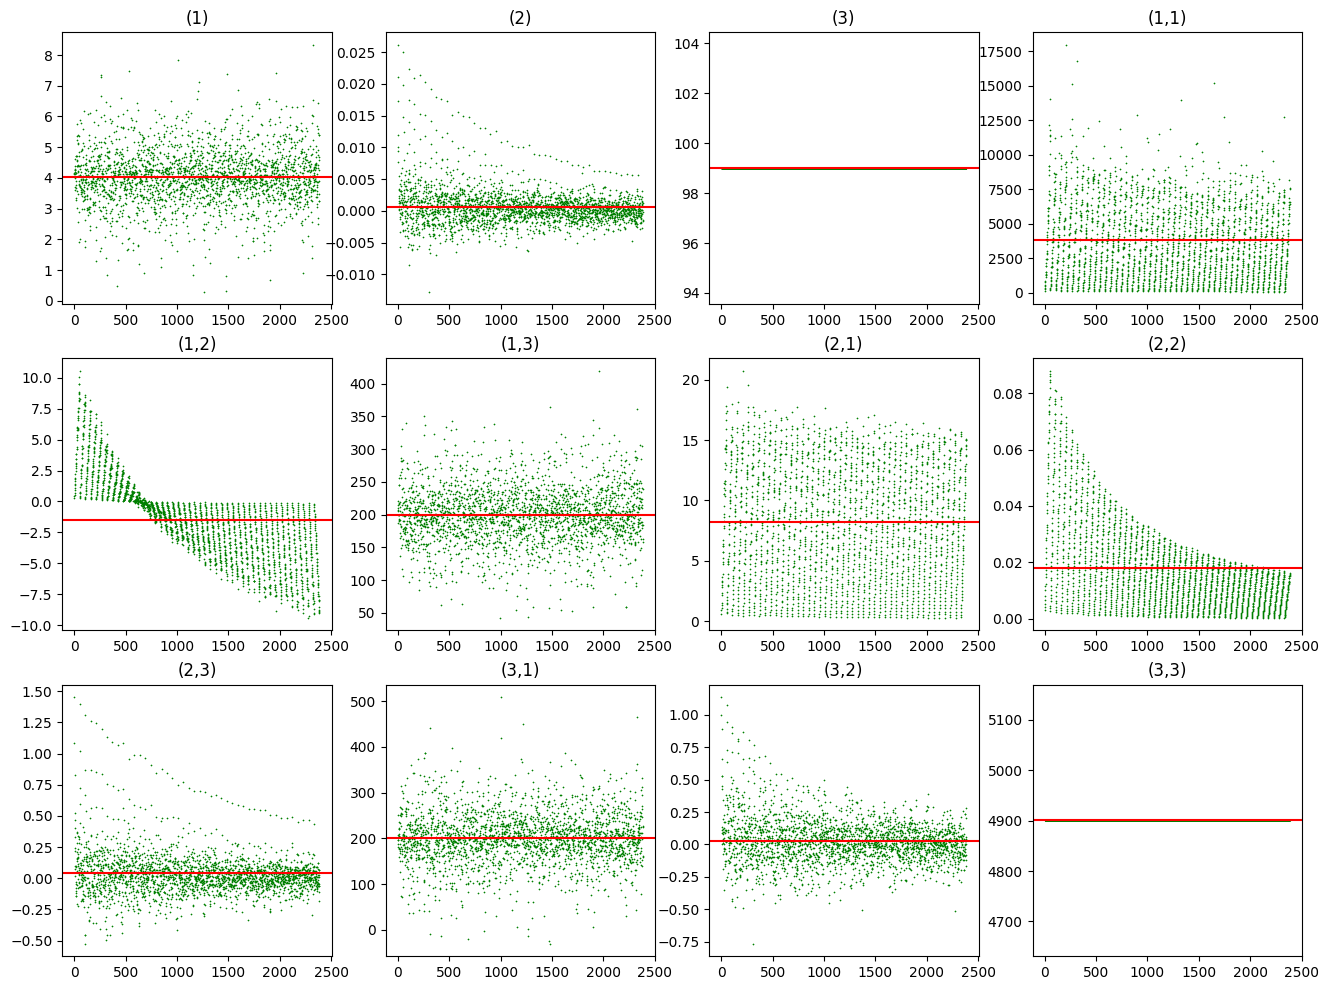

In [42]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2386),Exp_signatures_results_kappas_and_theta.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas_and_theta.T[i]), color='red')


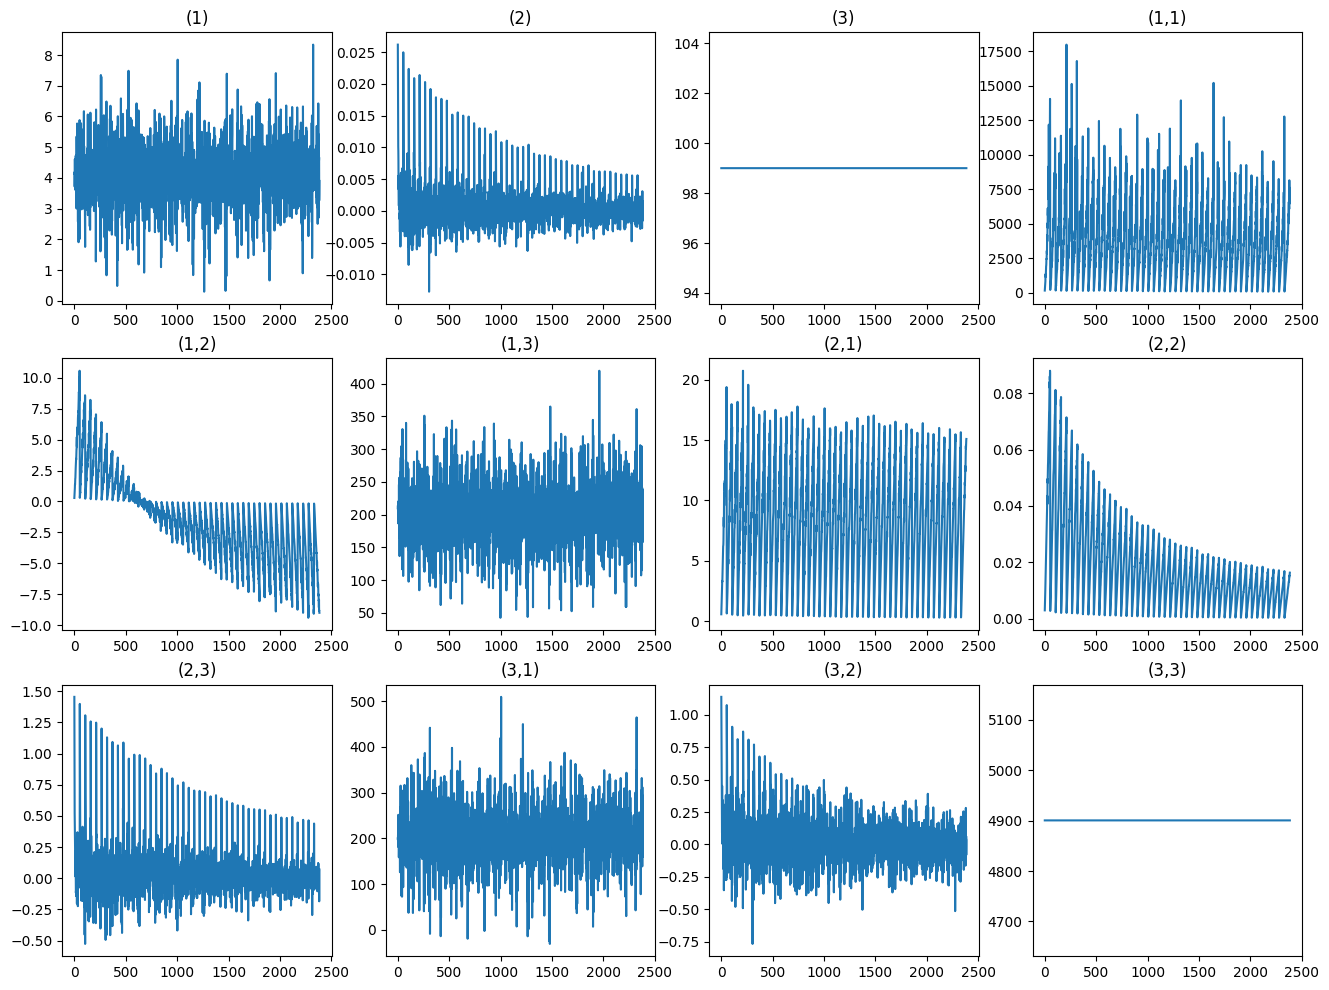

In [43]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas_and_theta.T[i])

In [45]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in by_parameter_2["by_thetas"]:
              for kappa in by_parameter_2["by_kappas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [46]:
number_of_loops=by_parameter_2["by_kappas"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [47]:
results_thetas_and_kappas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_thetas_and_kappas=results_thetas_and_kappas[0]
Exp_signatures_results_thetas_and_kappas=results_thetas_and_kappas[1]

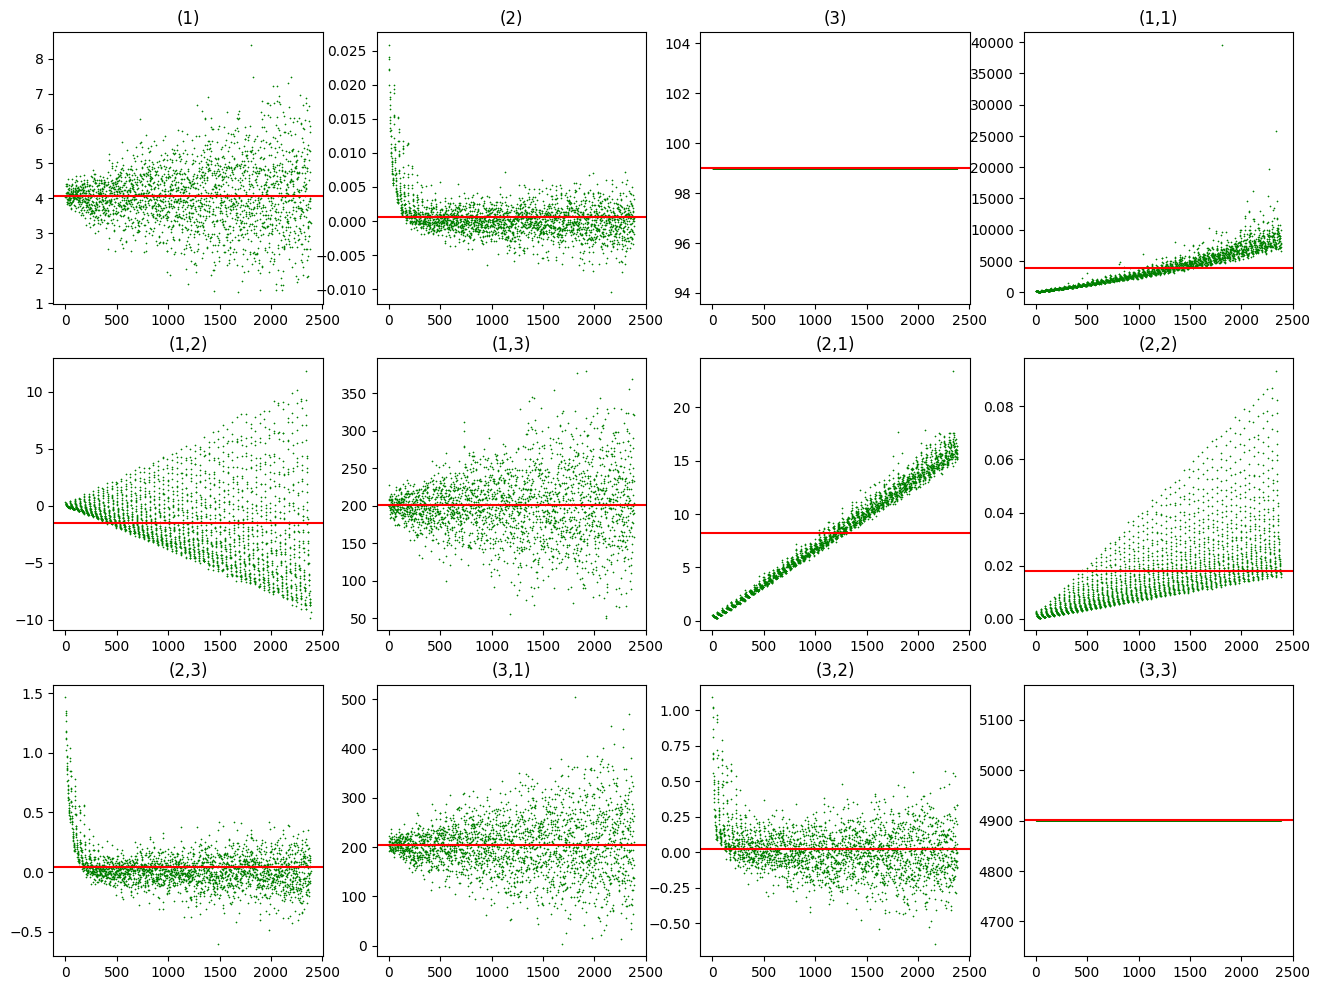

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2386),Exp_signatures_results_thetas_and_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas_and_kappas.T[i]), color='red')

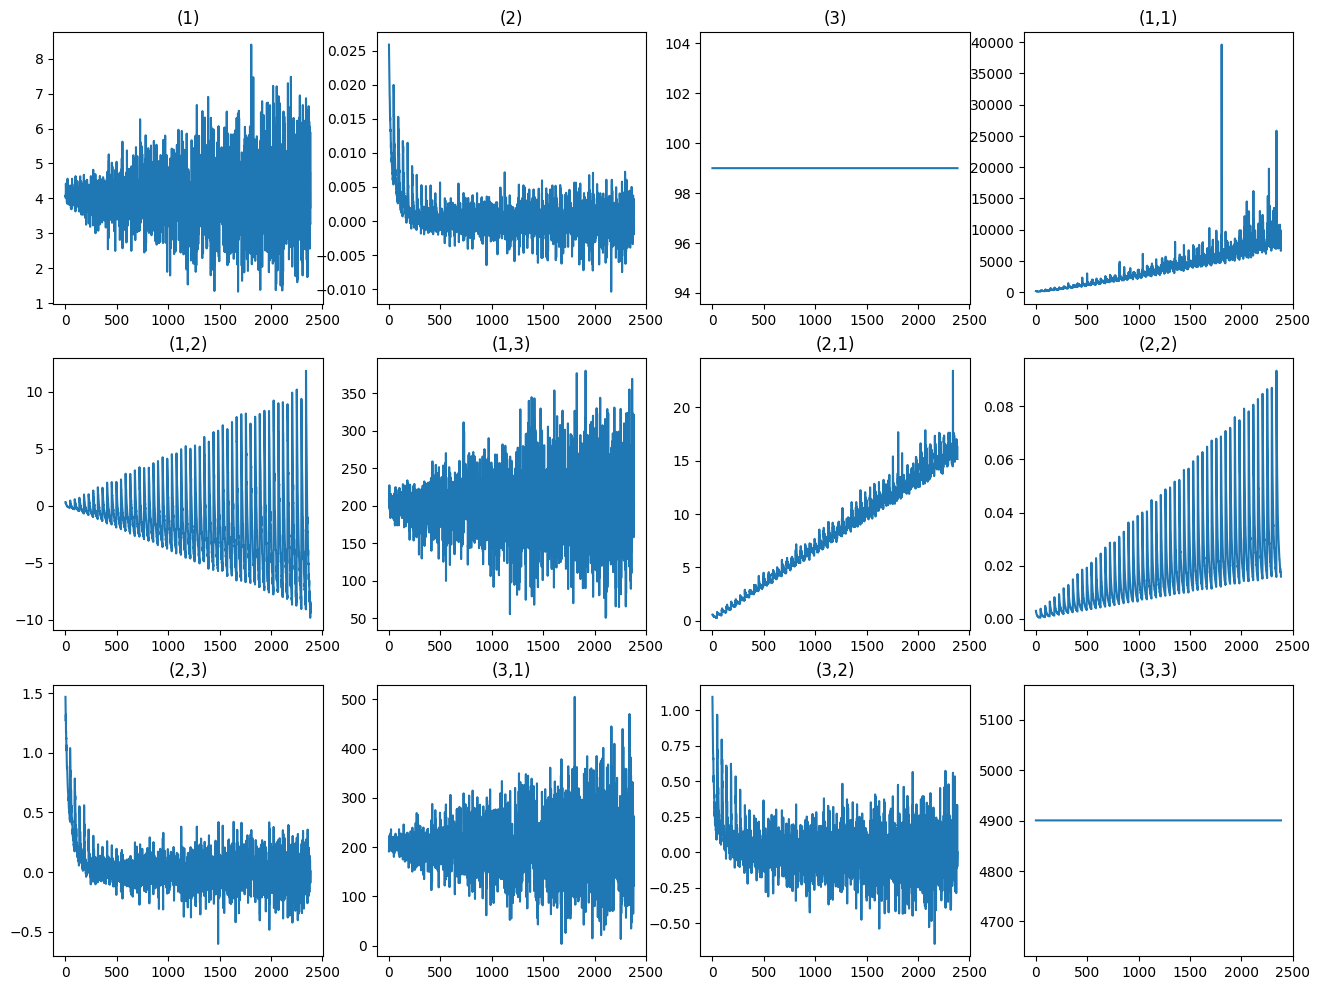

In [49]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_thetas_and_kappas.T[i])

In [12]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in by_parameter_2["by_thetas"]:
              for sigma in by_parameter_2["by_sigmas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 50, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [13]:
number_of_loops=by_parameter_2["by_sigmas"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [14]:
results_thetas_and_sigmas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_thetas_and_sigmas=results_thetas_and_sigmas[0]
Exp_signatures_results_thetas_and_sigmas=results_thetas_and_sigmas[1]

In [16]:
Exp_signatures_results_thetas_and_sigmas.T[0].shape

torch.Size([2915])

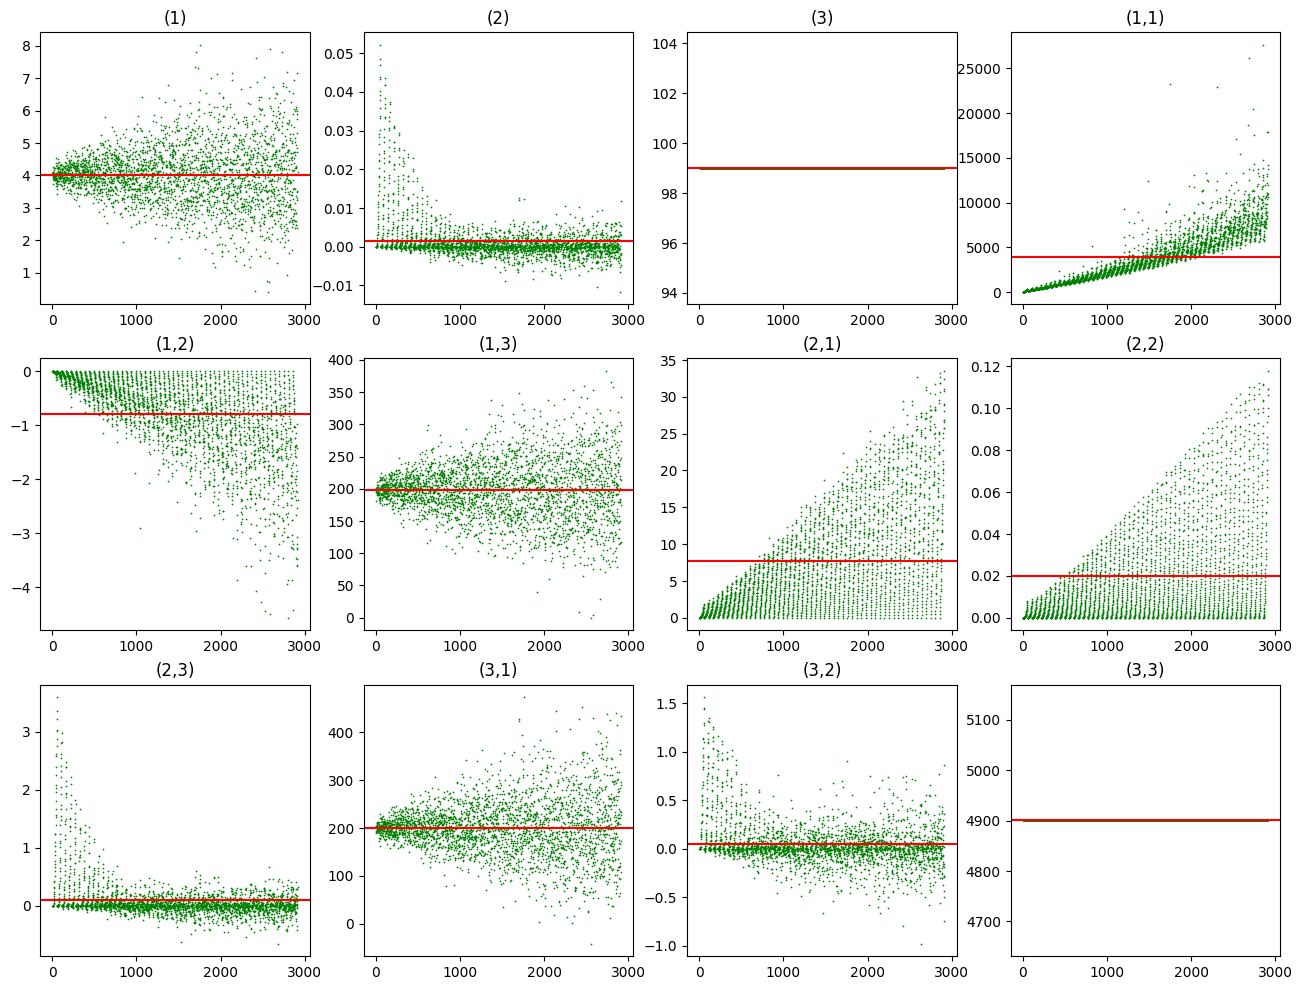

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2916),Exp_signatures_results_thetas_and_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas_and_sigmas.T[i]), color='red')

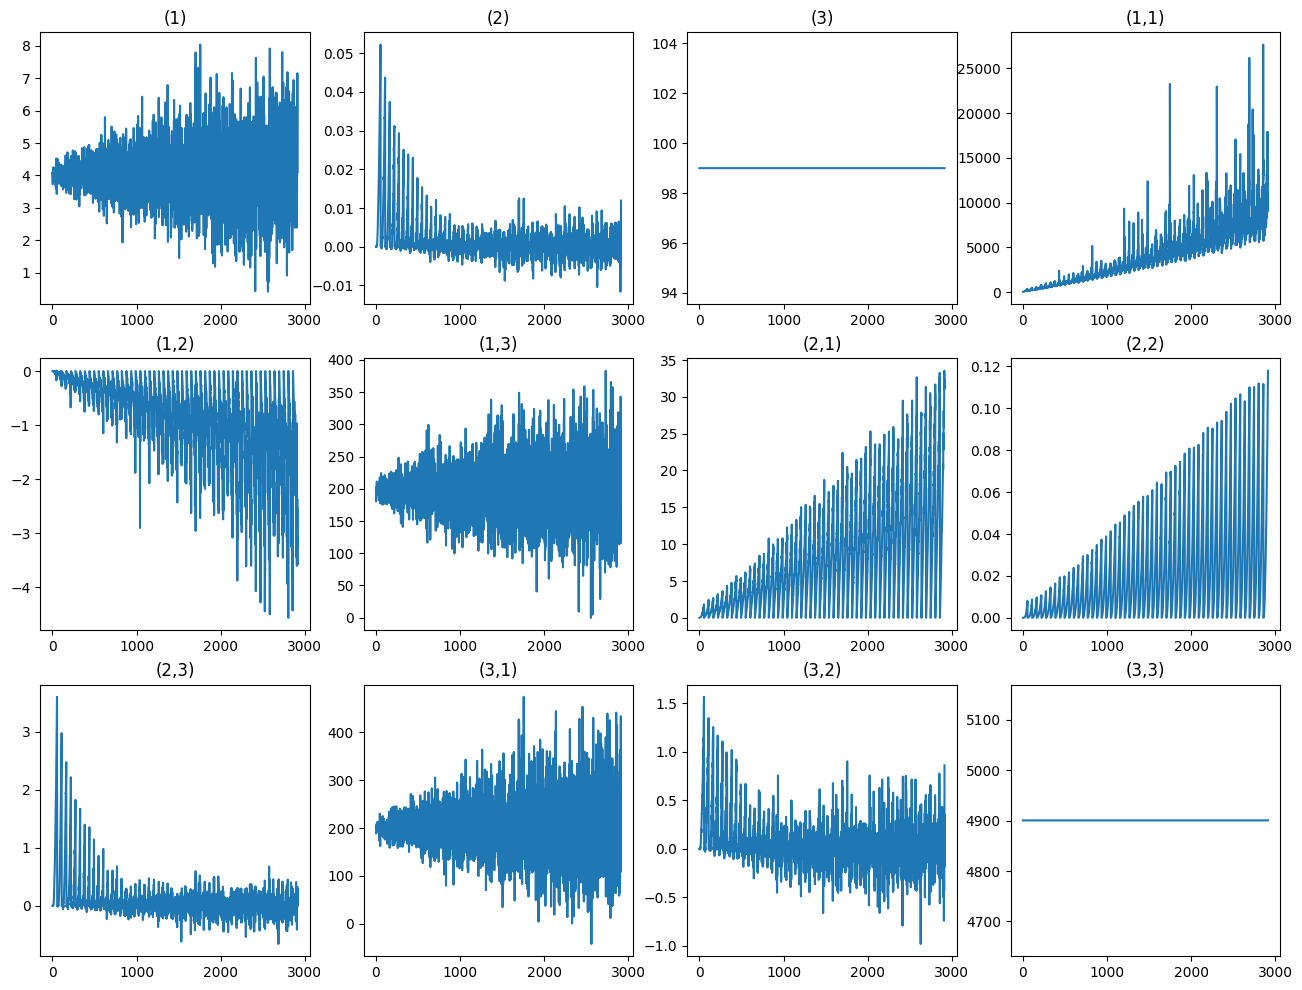

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_thetas_and_sigmas.T[i])

In [19]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in by_parameter_2["by_sigmas"]:
              for theta in by_parameter_2["by_thetas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [20]:
results_sigmas_and_thetas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_sigmas_and_thetas=results_sigmas_and_thetas[0]
Exp_signatures_results_sigmas_and_thetas=results_sigmas_and_thetas[1]

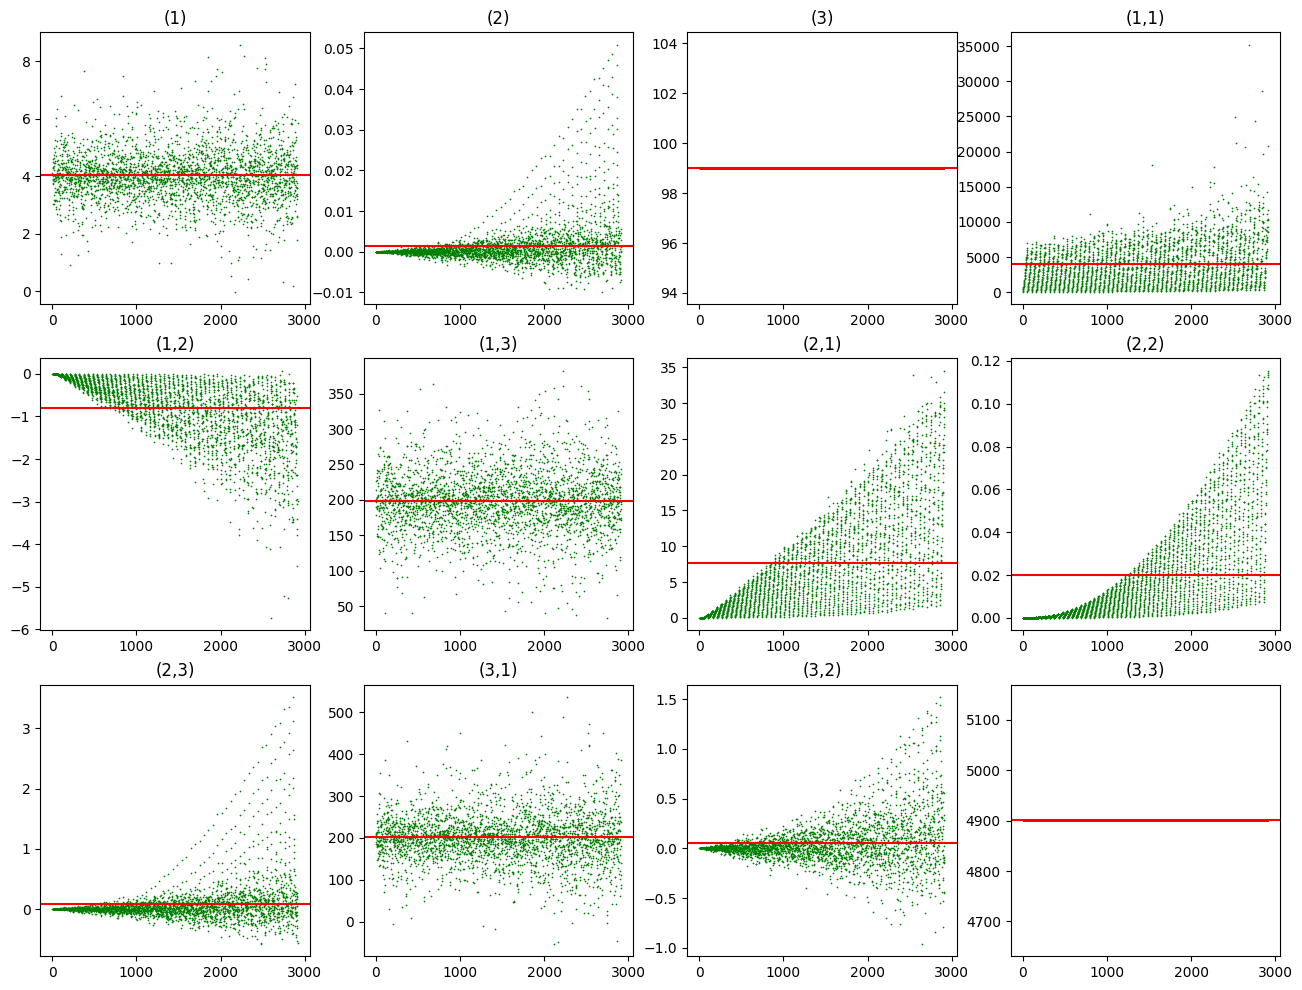

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2916),Exp_signatures_results_sigmas_and_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas_and_thetas.T[i]), color='red')

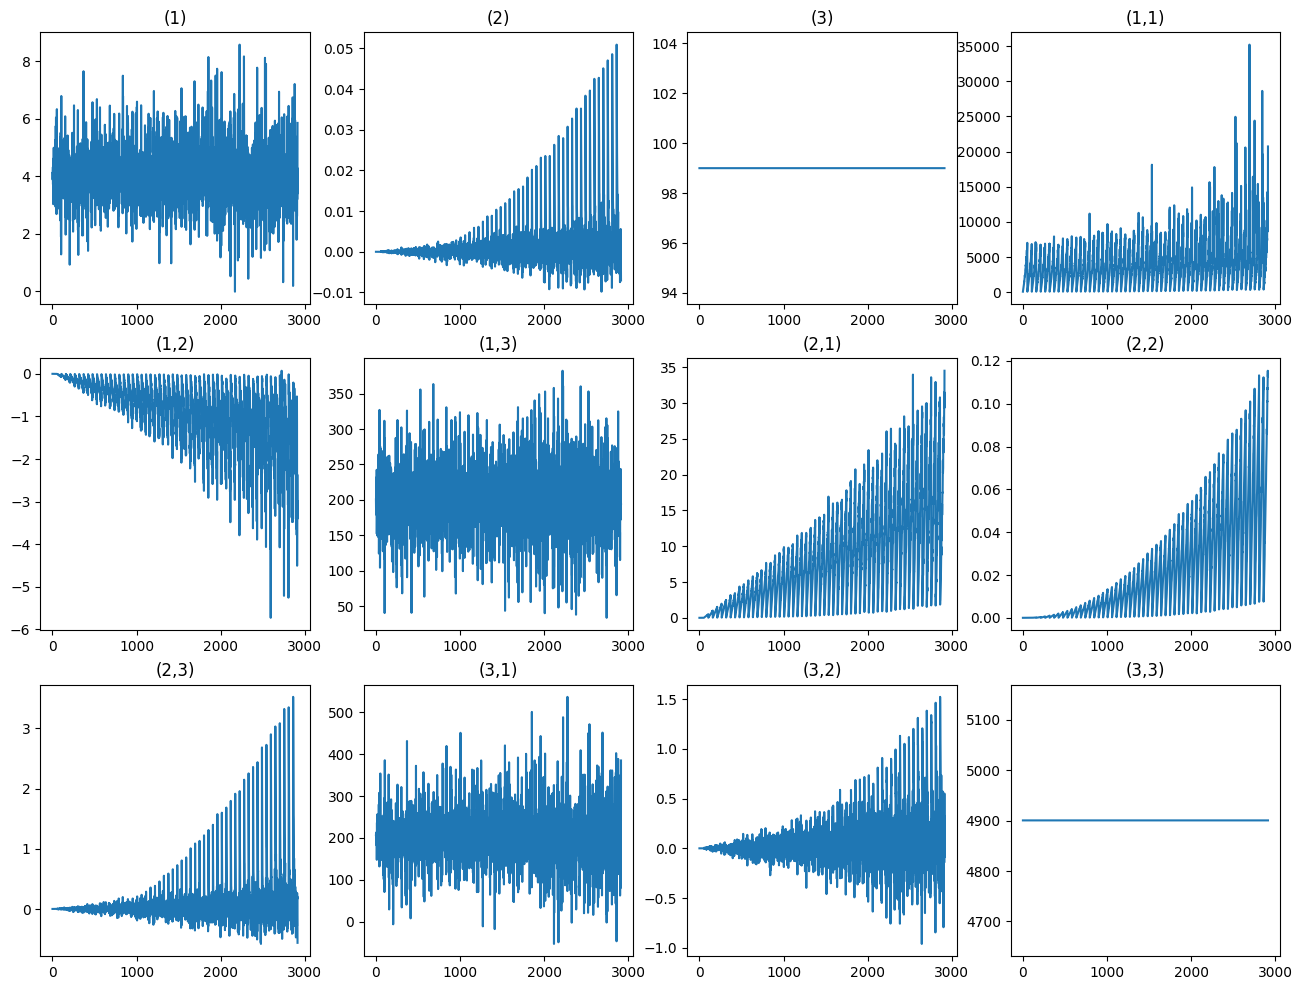

In [22]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas_and_thetas.T[i])

In [23]:
number_of_loops=by_parameter_2["by_sigmas"].shape[0]*by_parameter_2["by_kappas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [24]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in by_parameter_2["by_sigmas"]:
              for kappa in by_parameter_2["by_kappas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [25]:
results_sigmas_and_kappas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_sigmas_and_kappas=results_sigmas_and_kappas[0]
Exp_signatures_results_sigmas_and_kappas=results_sigmas_and_kappas[1]

In [26]:
Exp_signatures_results_sigmas_and_kappas.T[1].shape

torch.Size([2475])

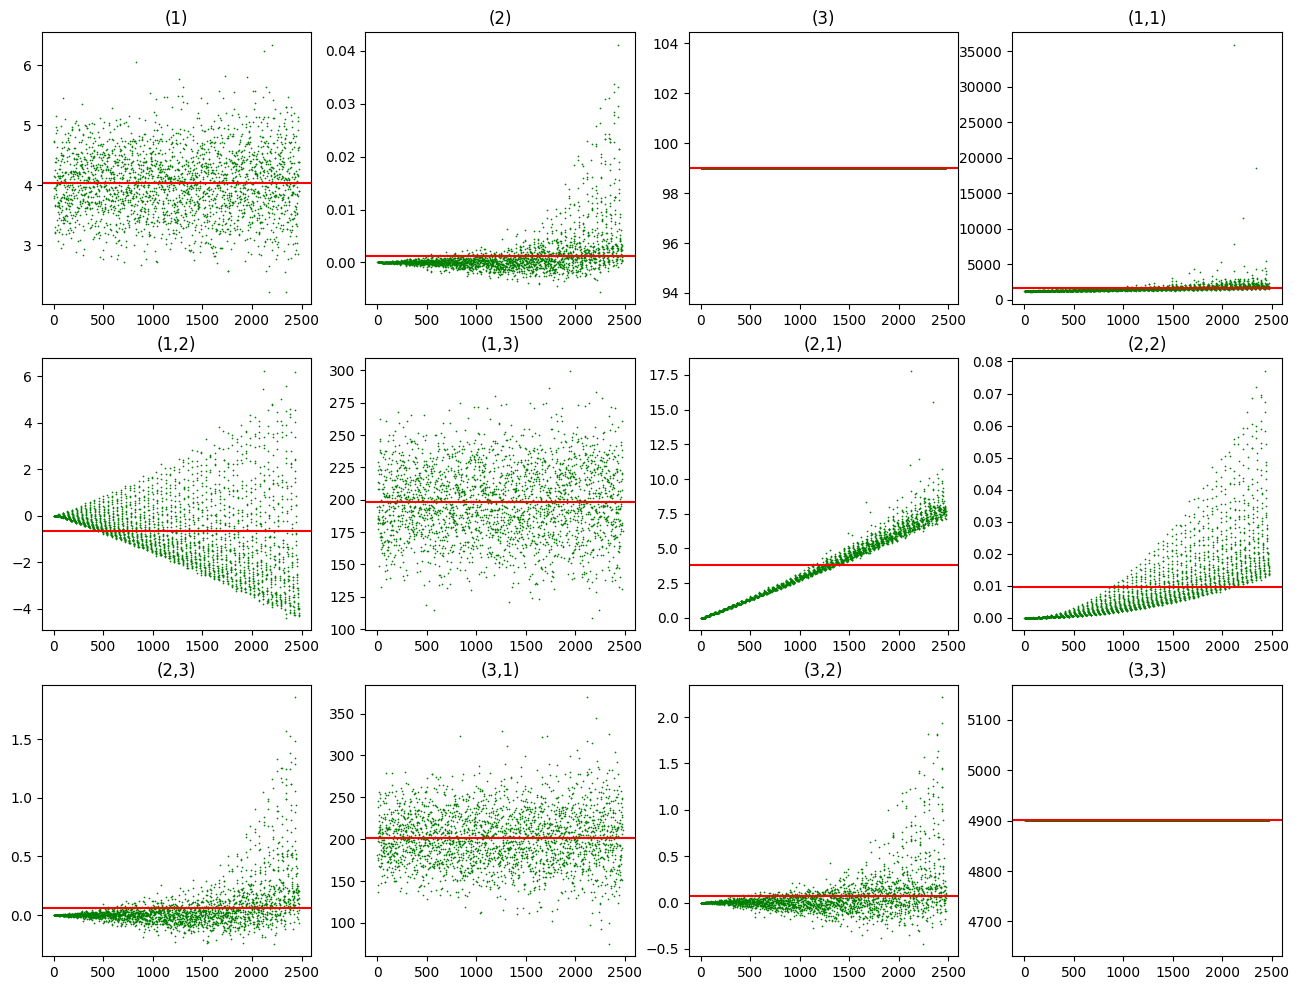

In [27]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2476),Exp_signatures_results_sigmas_and_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas_and_kappas.T[i]), color='red')

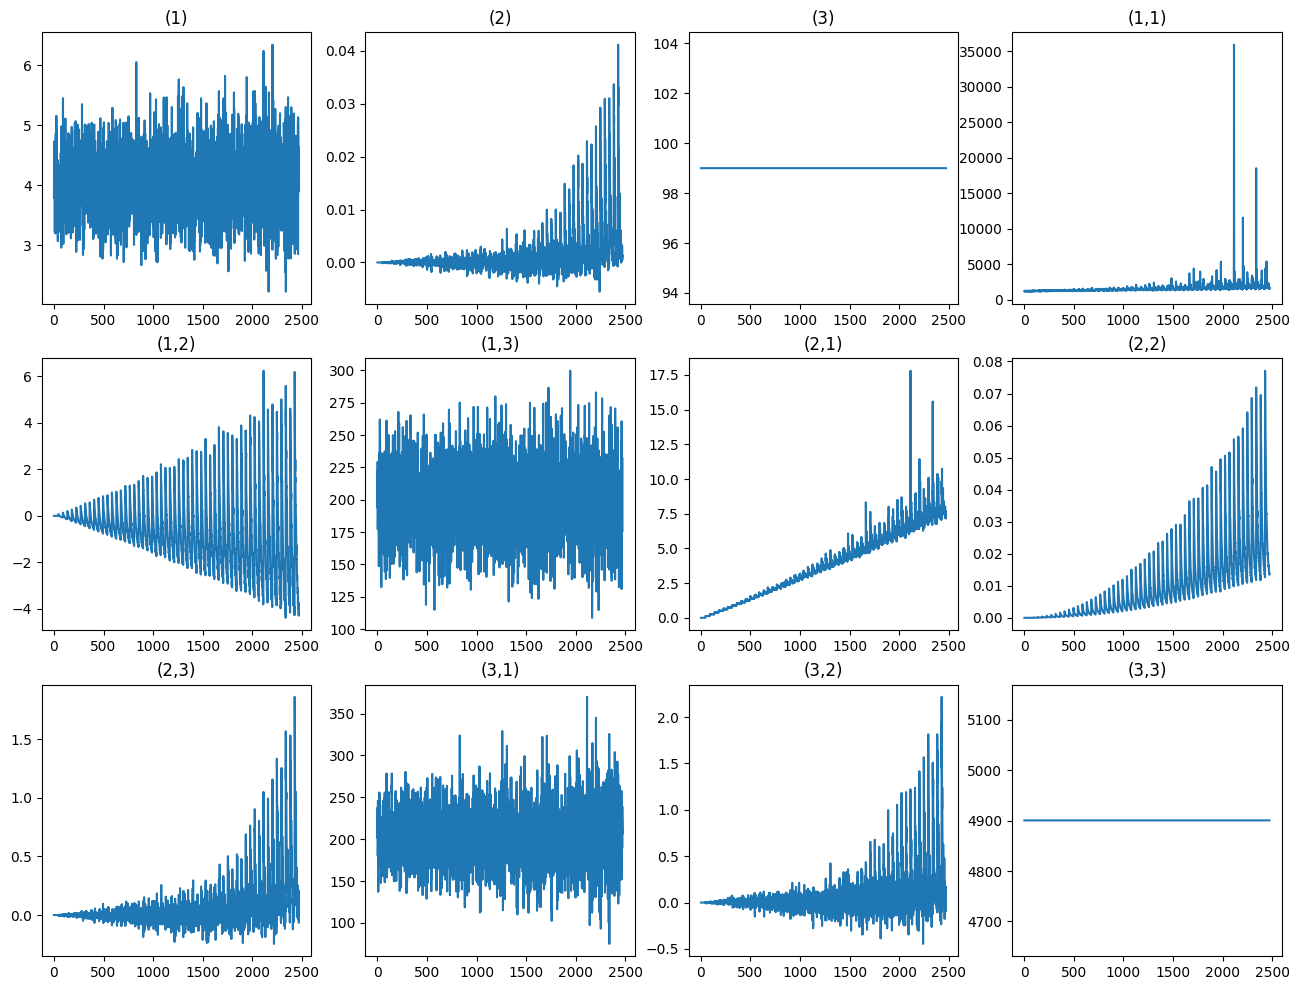

In [28]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas_and_kappas.T[i])

In [30]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in by_parameter_2["by_kappas"]:
              for sigma in by_parameter_2["by_sigmas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [31]:
results_kappas_and_sigmas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_kappas_and_sigmas=results_kappas_and_sigmas[0]
Exp_signatures_results_kappas_and_sigmas=results_kappas_and_sigmas[1]

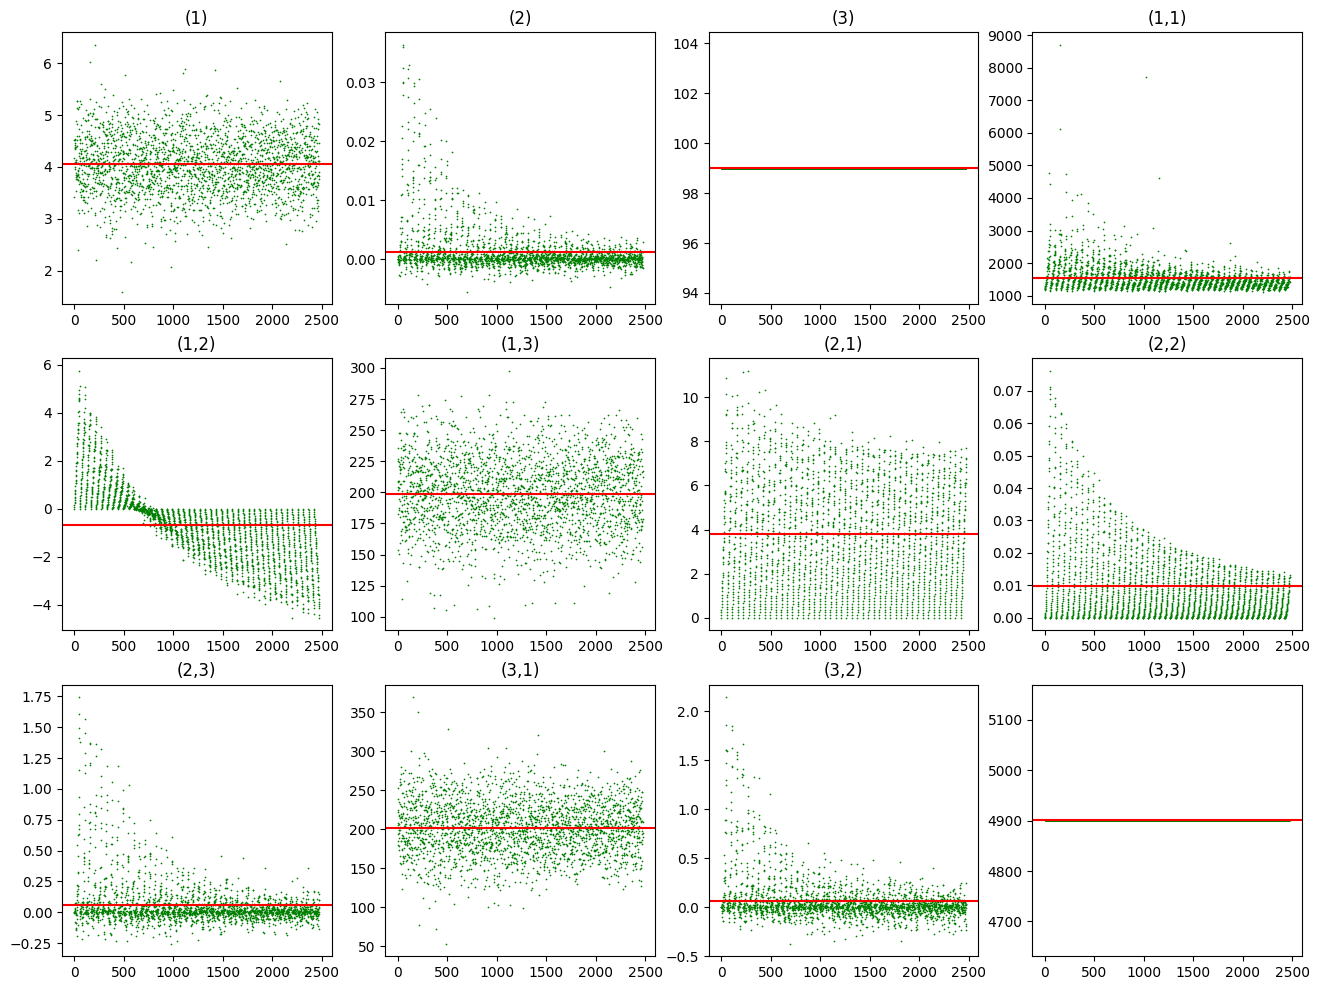

In [32]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2476),Exp_signatures_results_kappas_and_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas_and_sigmas.T[i]), color='red')

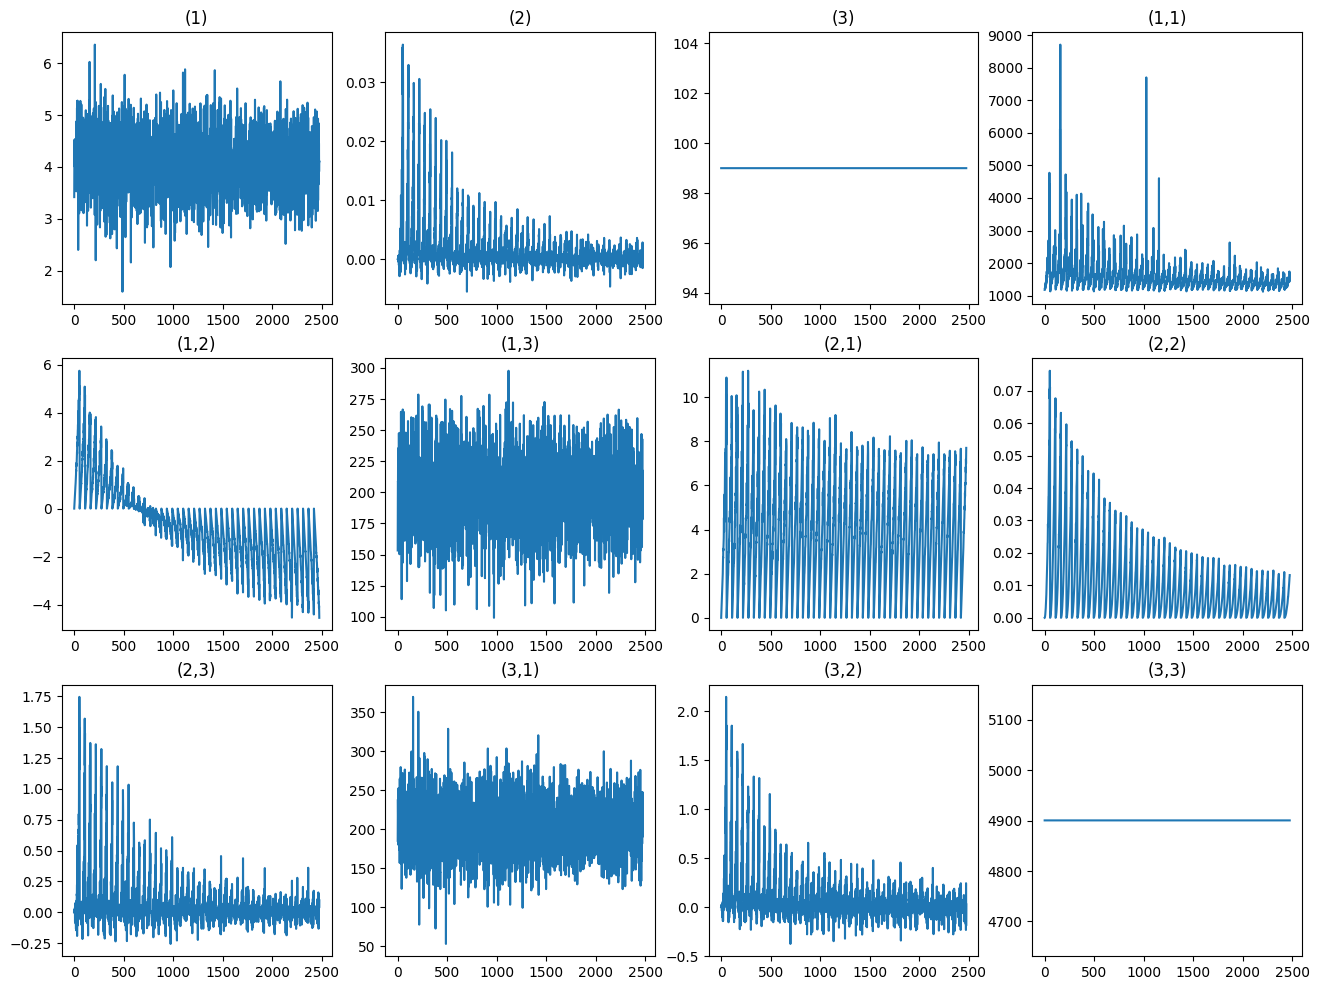

In [33]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas_and_sigmas.T[i])

In [34]:
number_of_loops=by_parameter_2["by_rhos"].shape[0]*by_parameter_2["by_sigmas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [42]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for rho in by_parameter_2["by_rhos"]:
              for sigma in by_parameter_2["by_sigmas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([3025, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([3025, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [43]:
results_rhos_and_sigmas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_rhos_and_sigmas=results_rhos_and_sigmas[0]
Exp_signatures_results_rhos_and_sigmas=results_rhos_and_sigmas[1]

In [40]:
Exp_signatures_results_rhos_and_sigmas.T[1].shape

torch.Size([3025])

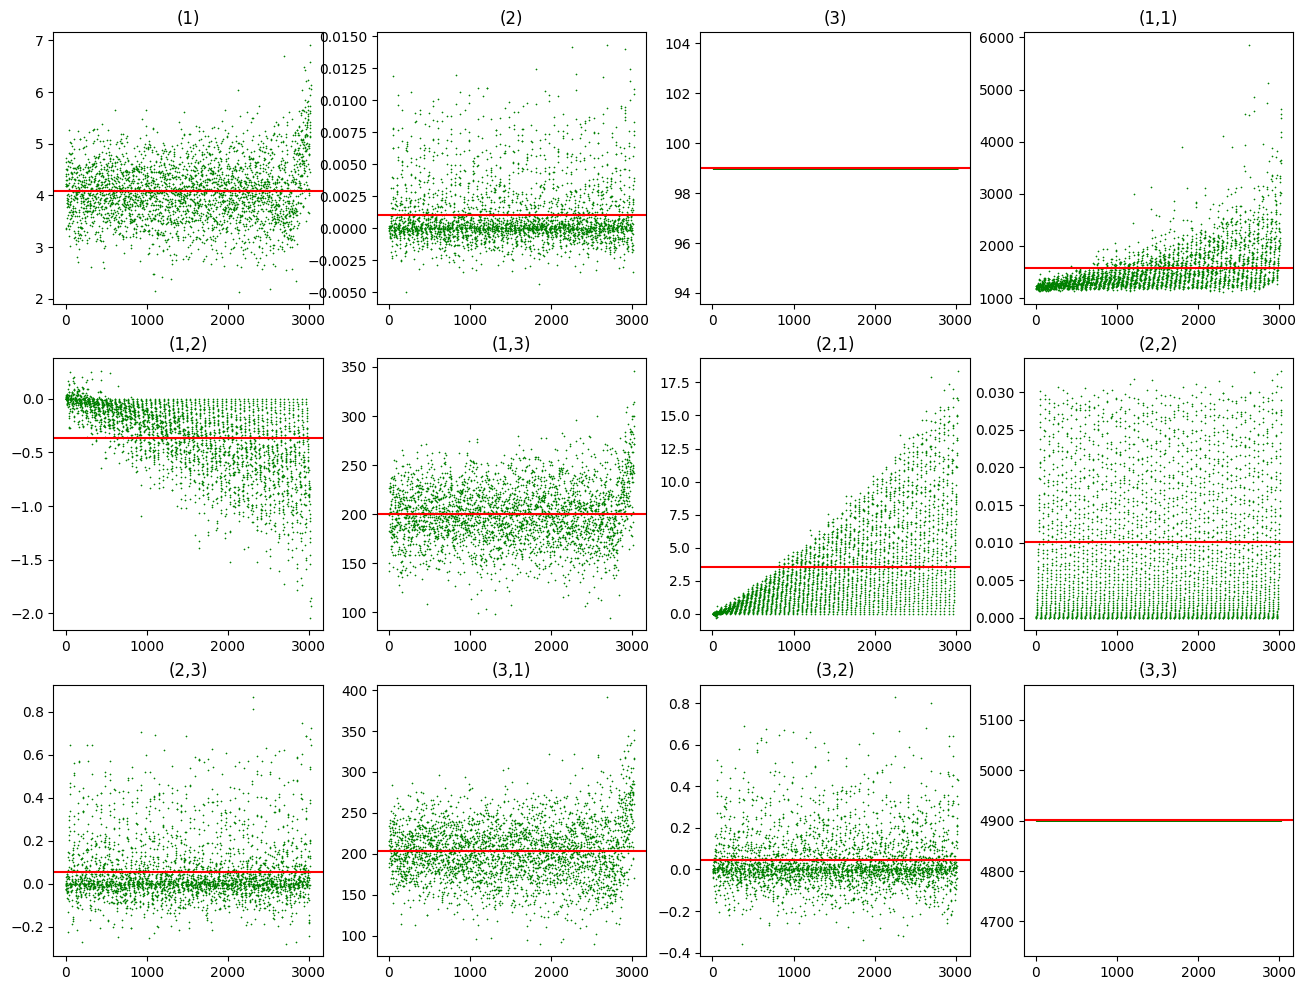

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,3026),Exp_signatures_results_rhos_and_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rhos_and_sigmas.T[i]), color='red')

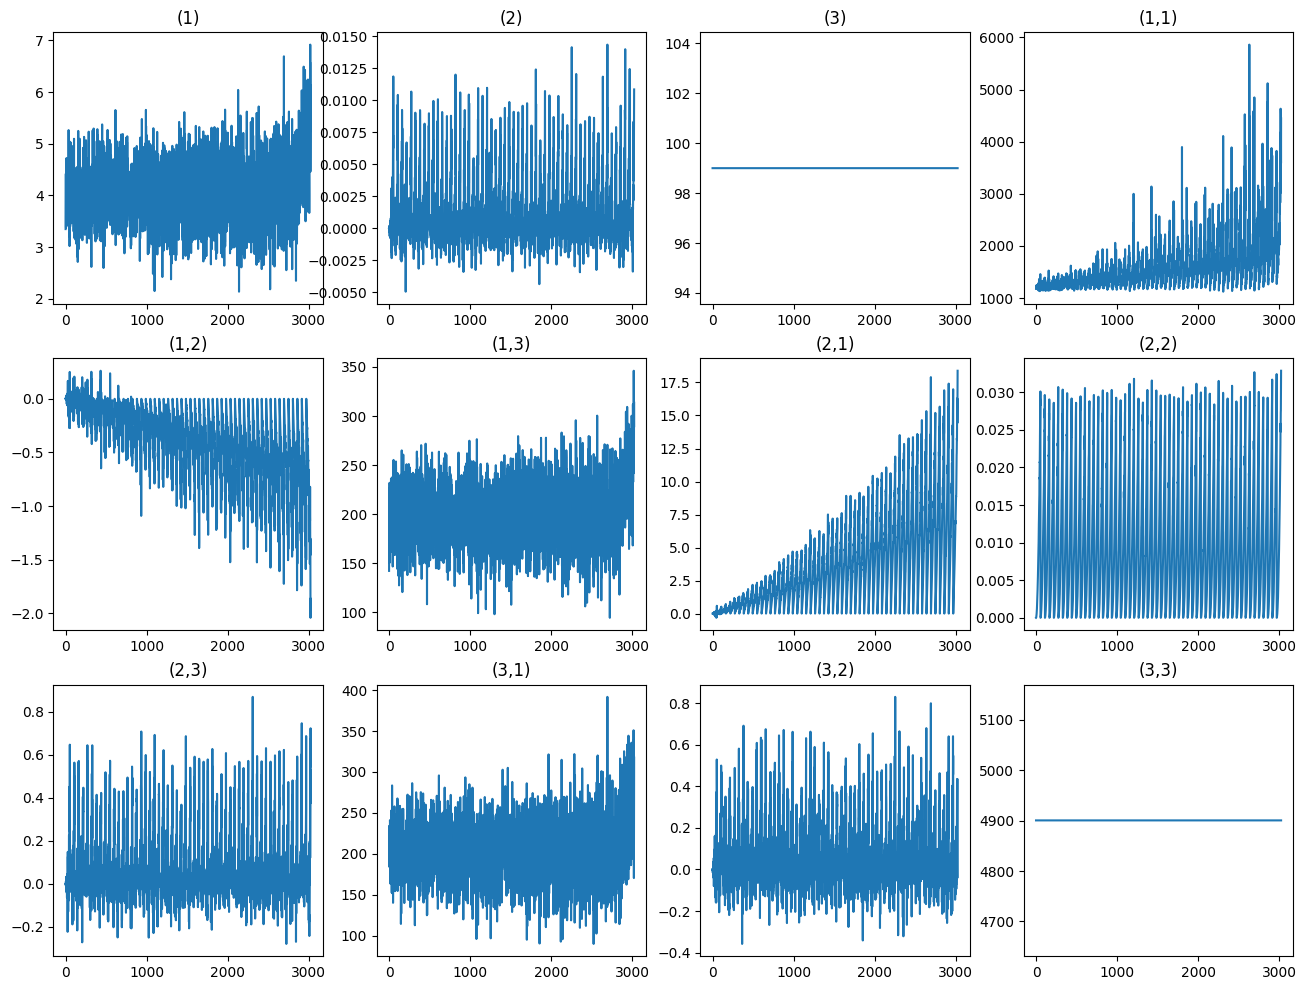

In [45]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_rhos_and_sigmas.T[i])

In [46]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in by_parameter_2["by_sigmas"]:
              for rho in by_parameter_2["by_rhos"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([3025, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([3025, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [47]:
results_sigmas_and_rhos=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_sigmas_and_rhos=results_sigmas_and_rhos[0]
Exp_signatures_results_sigmas_and_rhos=results_sigmas_and_rhos[1]

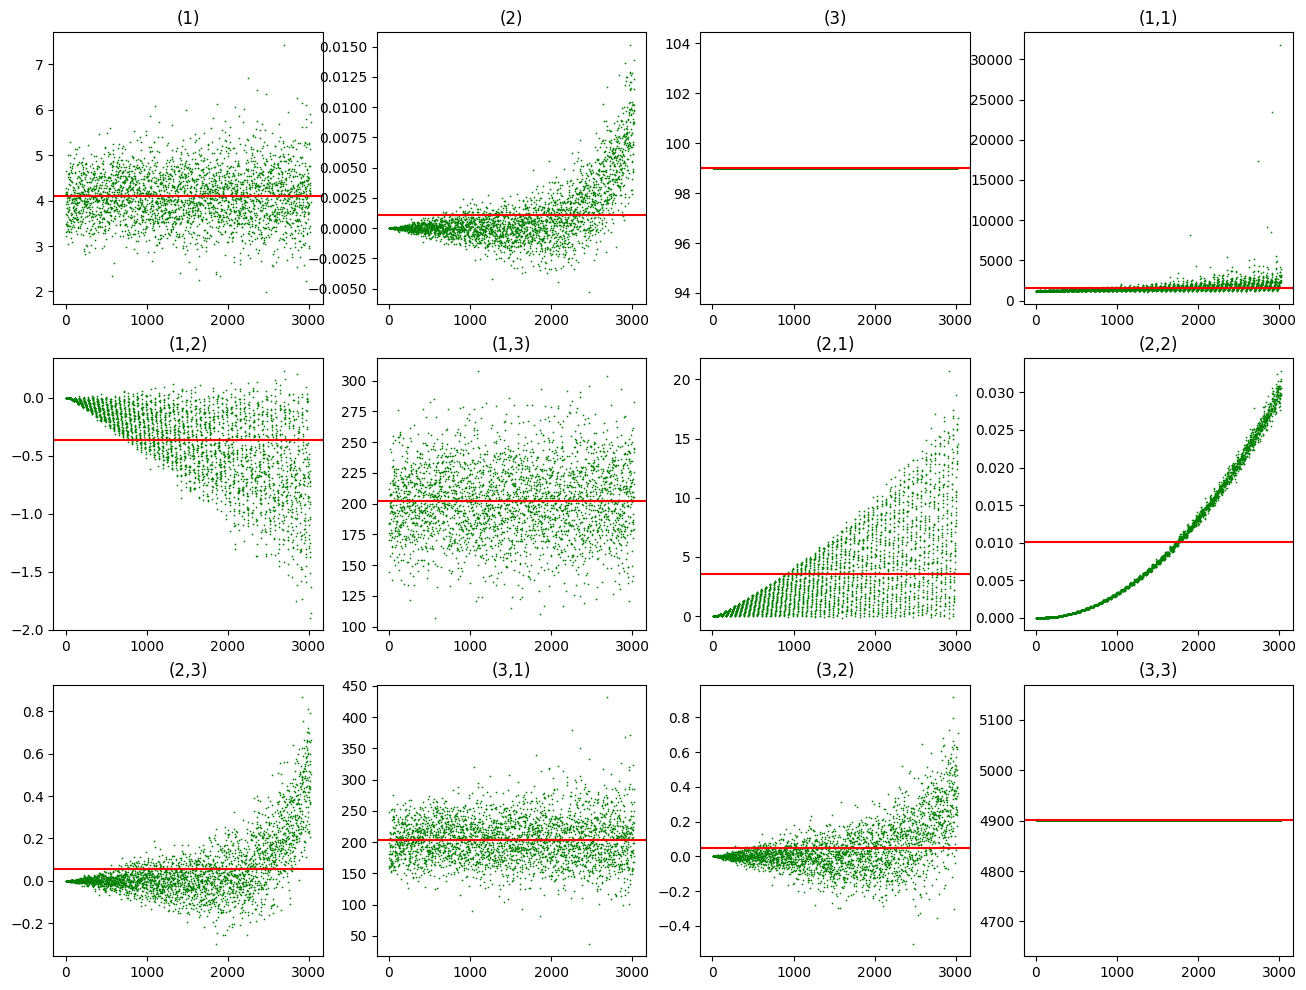

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,3026),Exp_signatures_results_sigmas_and_rhos.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas_and_rhos.T[i]), color='red')

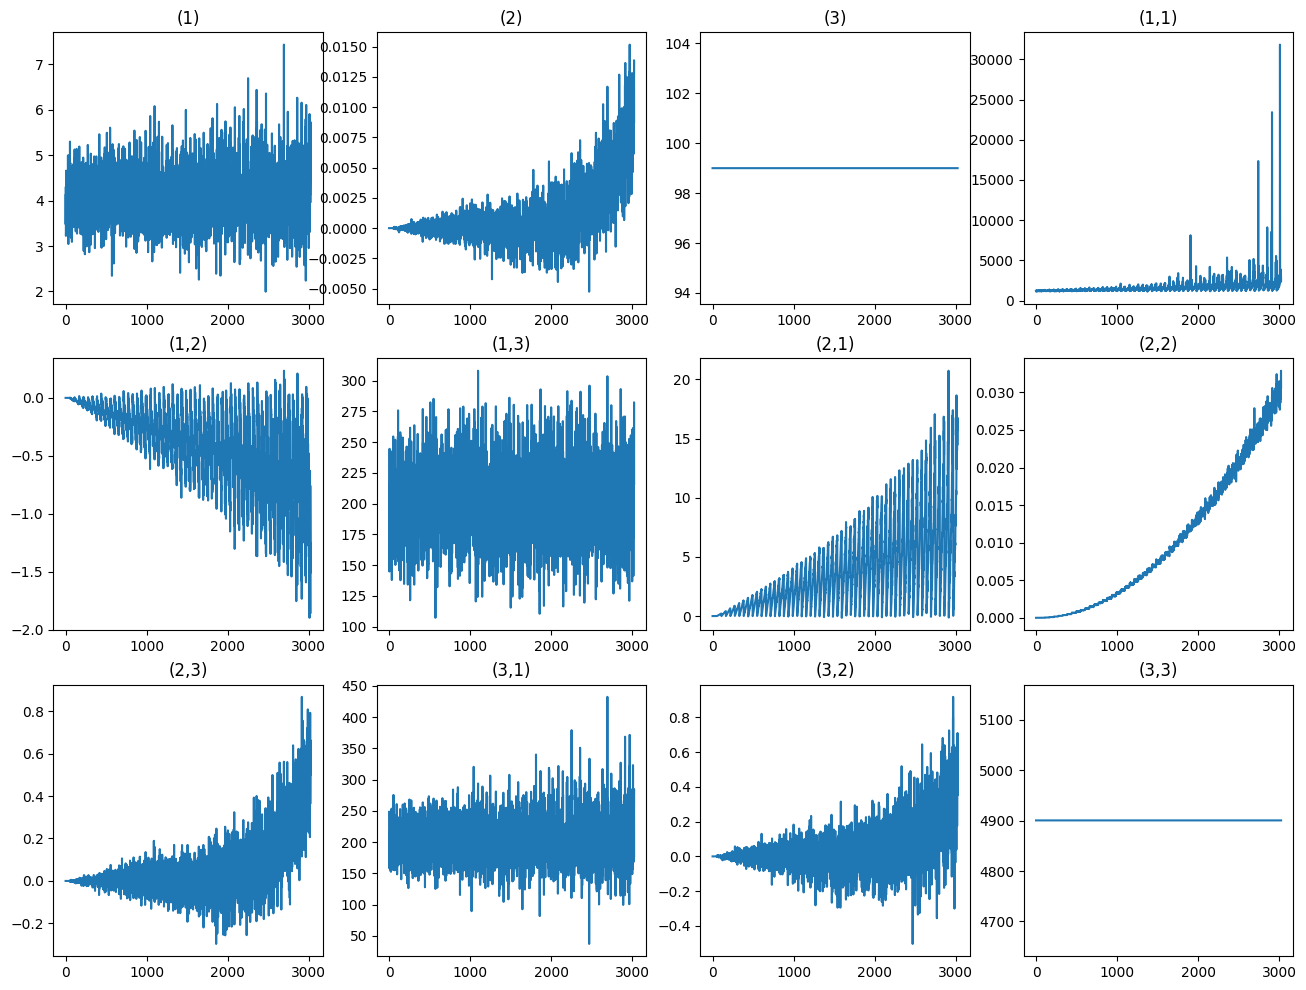

In [49]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas_and_rhos.T[i])

In [50]:
number_of_loops=by_parameter_2["by_rhos"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [51]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in by_parameter_2["by_thetas"]:
              for rho in by_parameter_2["by_rhos"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [52]:
results_thetas_and_rhos=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_thetas_and_rhos=results_thetas_and_rhos[0]
Exp_signatures_results_thetas_and_rhos=results_thetas_and_rhos[1]

In [54]:
Exp_signatures_results_thetas_and_rhos.T[1].shape

torch.Size([2915])

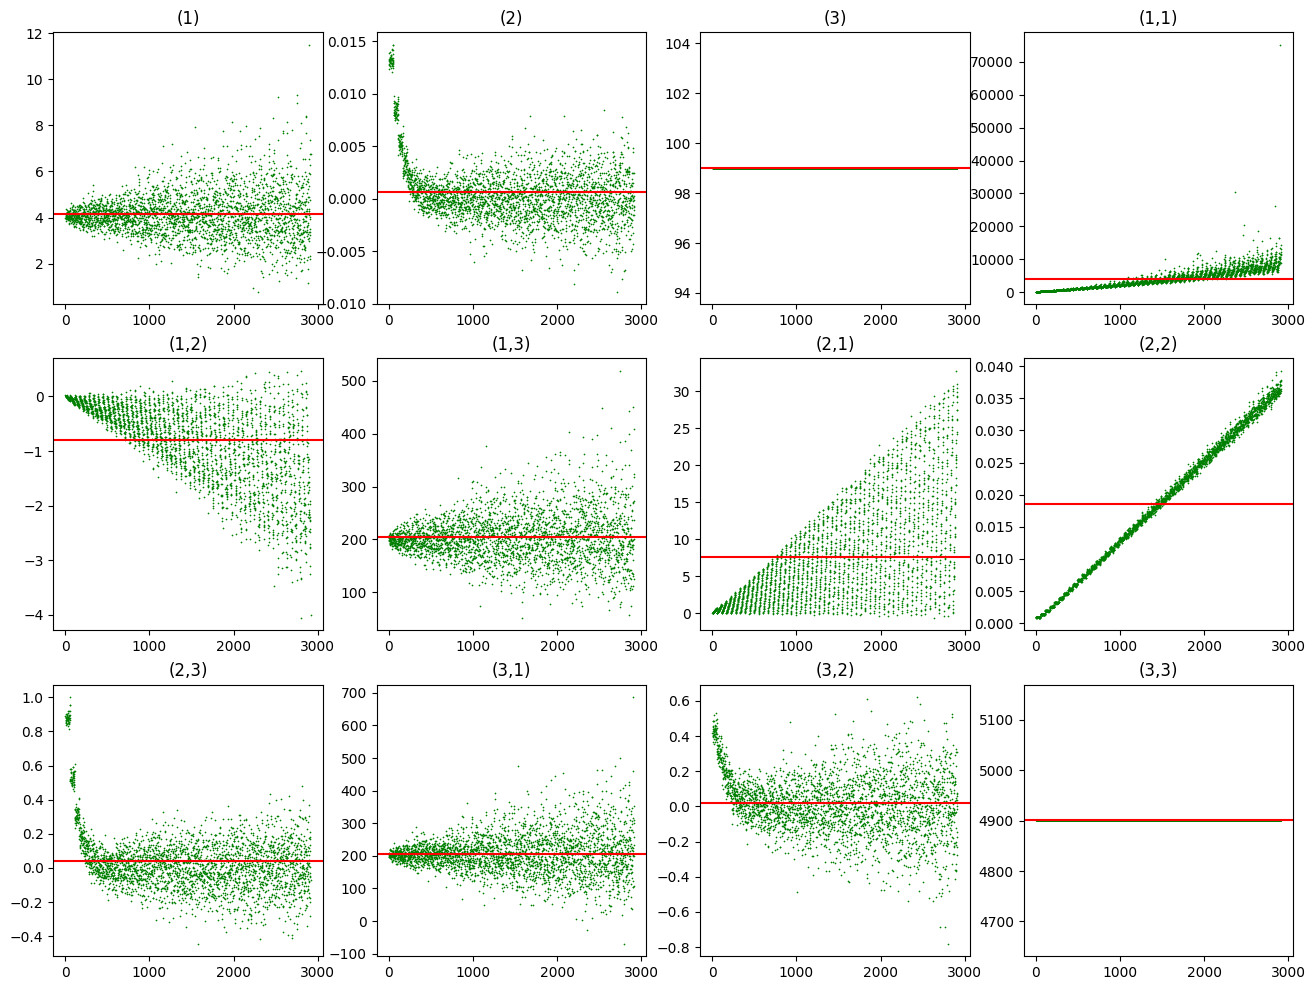

In [55]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2916),Exp_signatures_results_thetas_and_rhos.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas_and_rhos.T[i]), color='red')

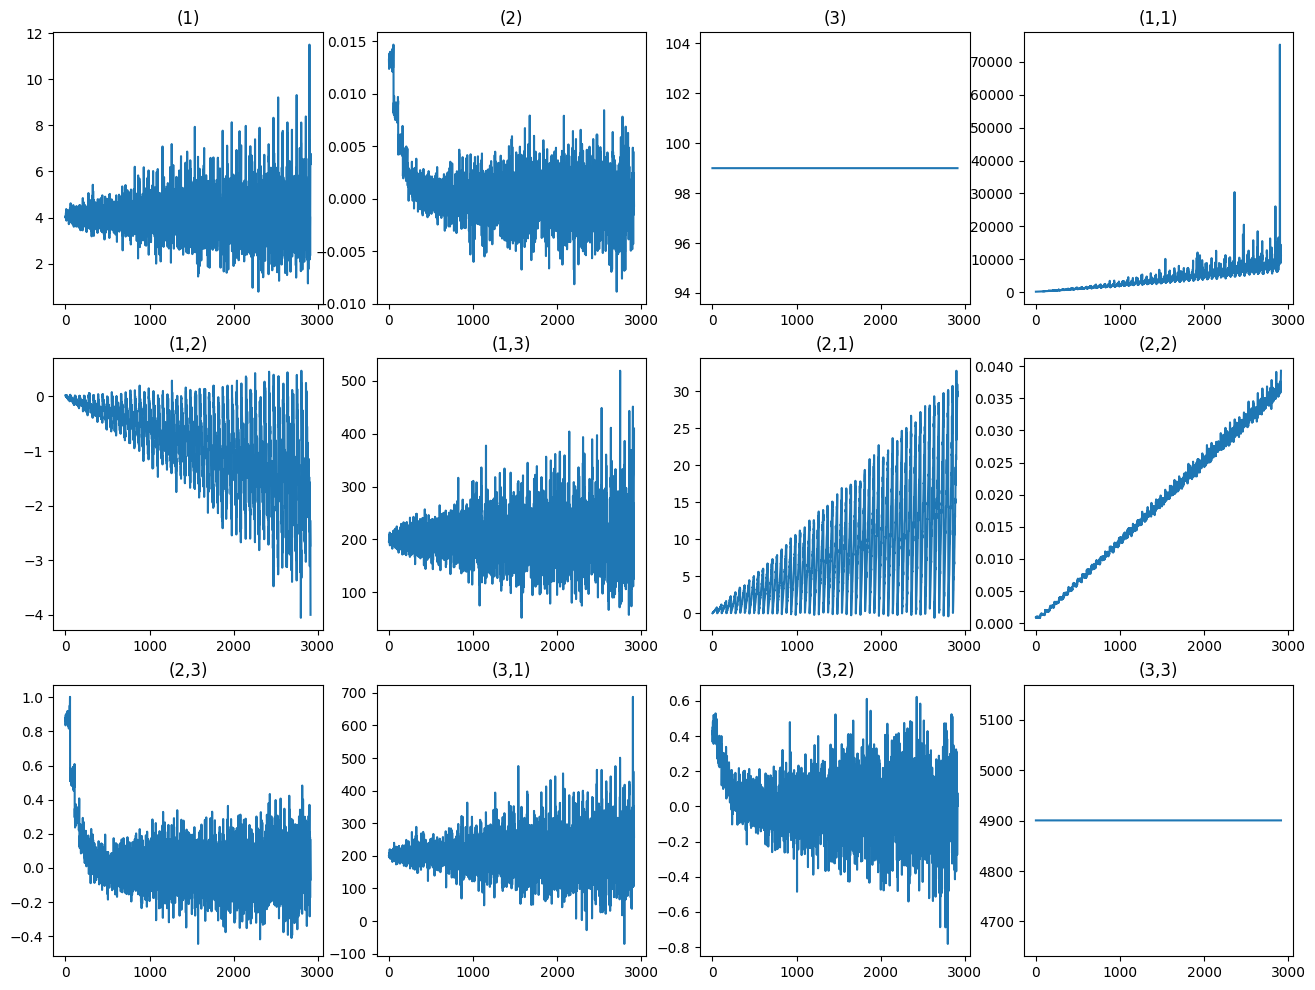

In [56]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_thetas_and_rhos.T[i])

In [57]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for rho in by_parameter_2["by_rhos"]:
              for theta in by_parameter_2["by_thetas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [58]:
results_rhos_and_thetas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_rhos_and_thetas=results_rhos_and_thetas[0]
Exp_signatures_results_rhos_and_thetas=results_rhos_and_thetas[1]

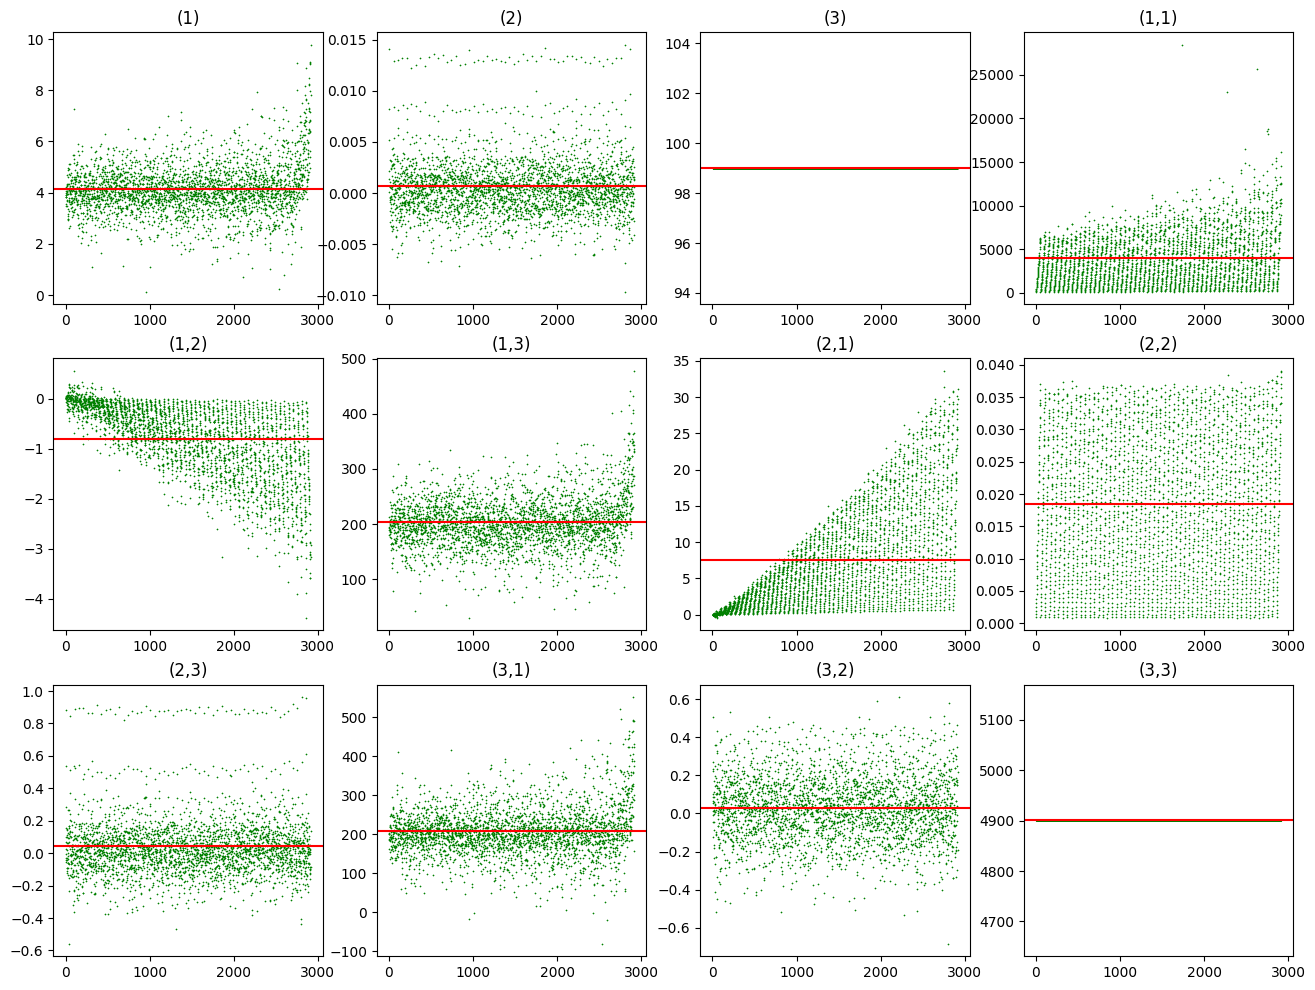

In [59]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2916),Exp_signatures_results_rhos_and_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rhos_and_thetas.T[i]), color='red')

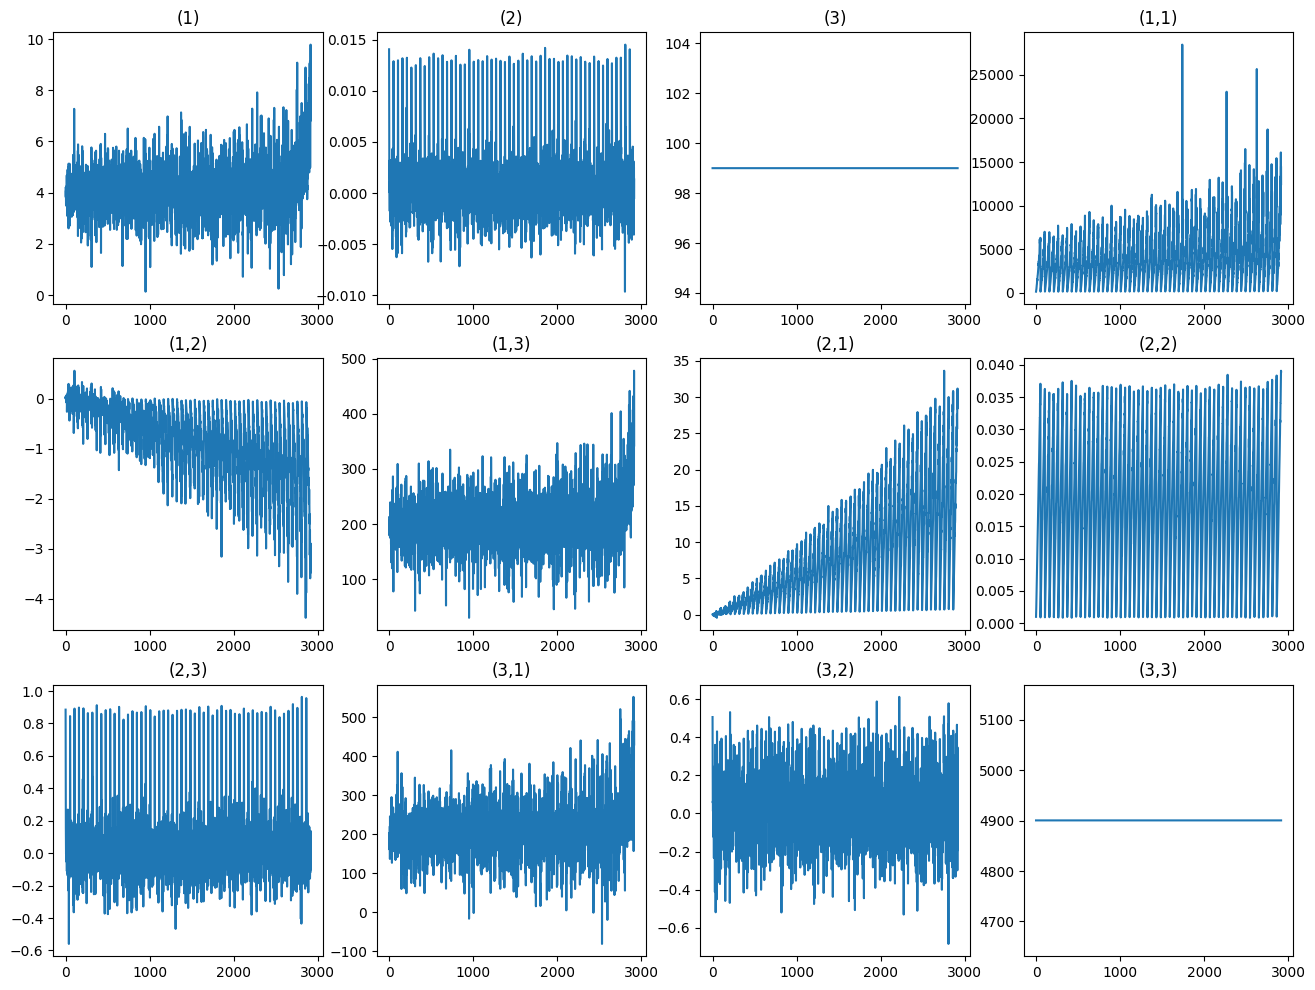

In [60]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_rhos_and_thetas.T[i])

In [61]:
number_of_loops=by_parameter_2["by_rhos"].shape[0]*by_parameter_2["by_kappas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [62]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for rho in by_parameter_2["by_rhos"]:
              for kappa in by_parameter_2["by_kappas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2475, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2475, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [63]:
results_rhos_and_kappas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_rhos_and_kappas=results_rhos_and_kappas[0]
Exp_signatures_results_rhos_and_kappas=results_rhos_and_kappas[1]

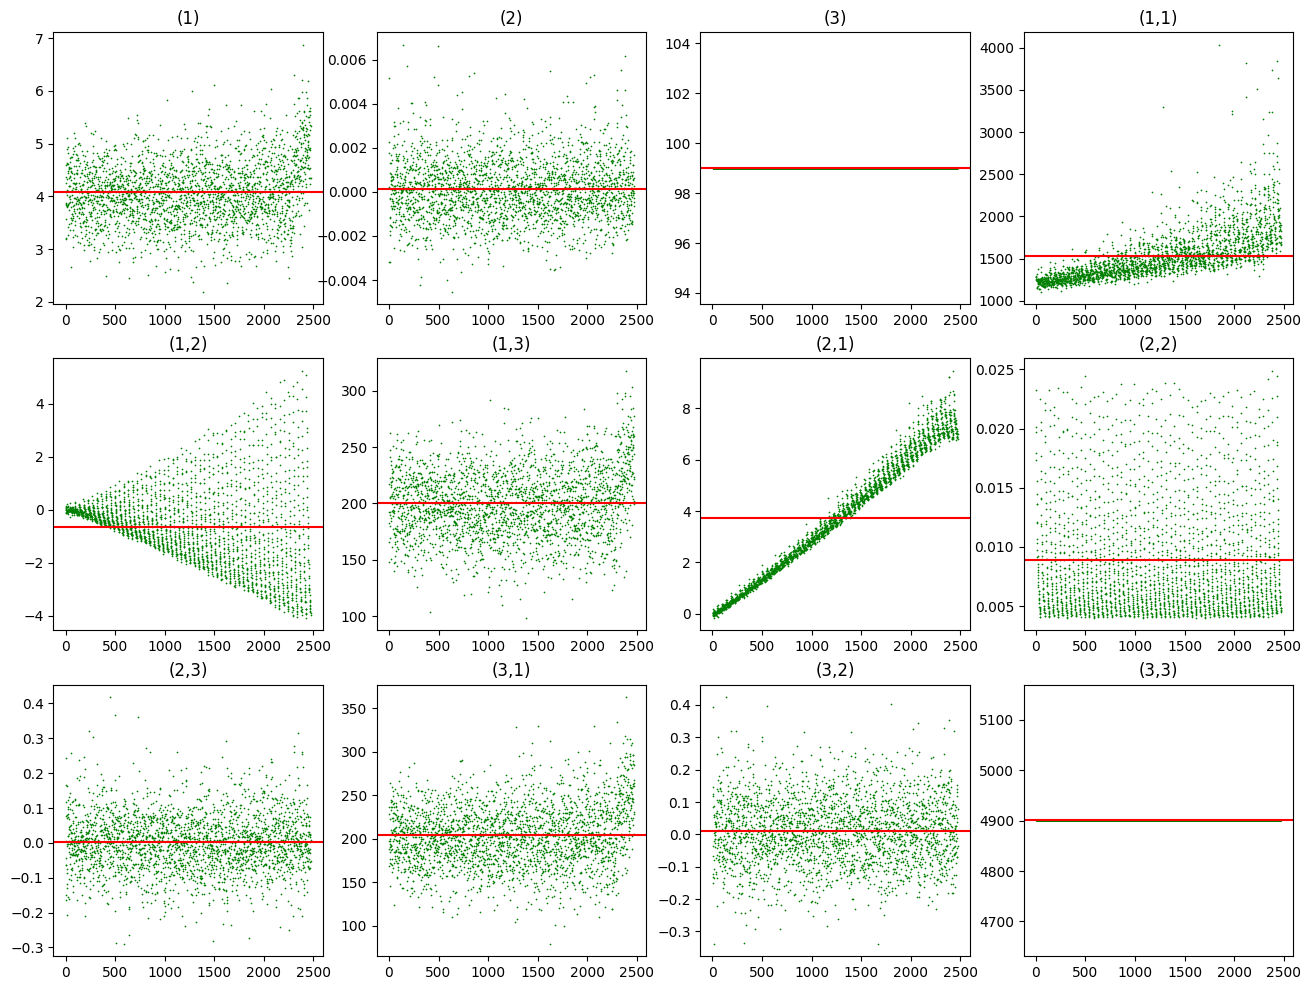

In [64]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2476),Exp_signatures_results_rhos_and_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rhos_and_kappas.T[i]), color='red')

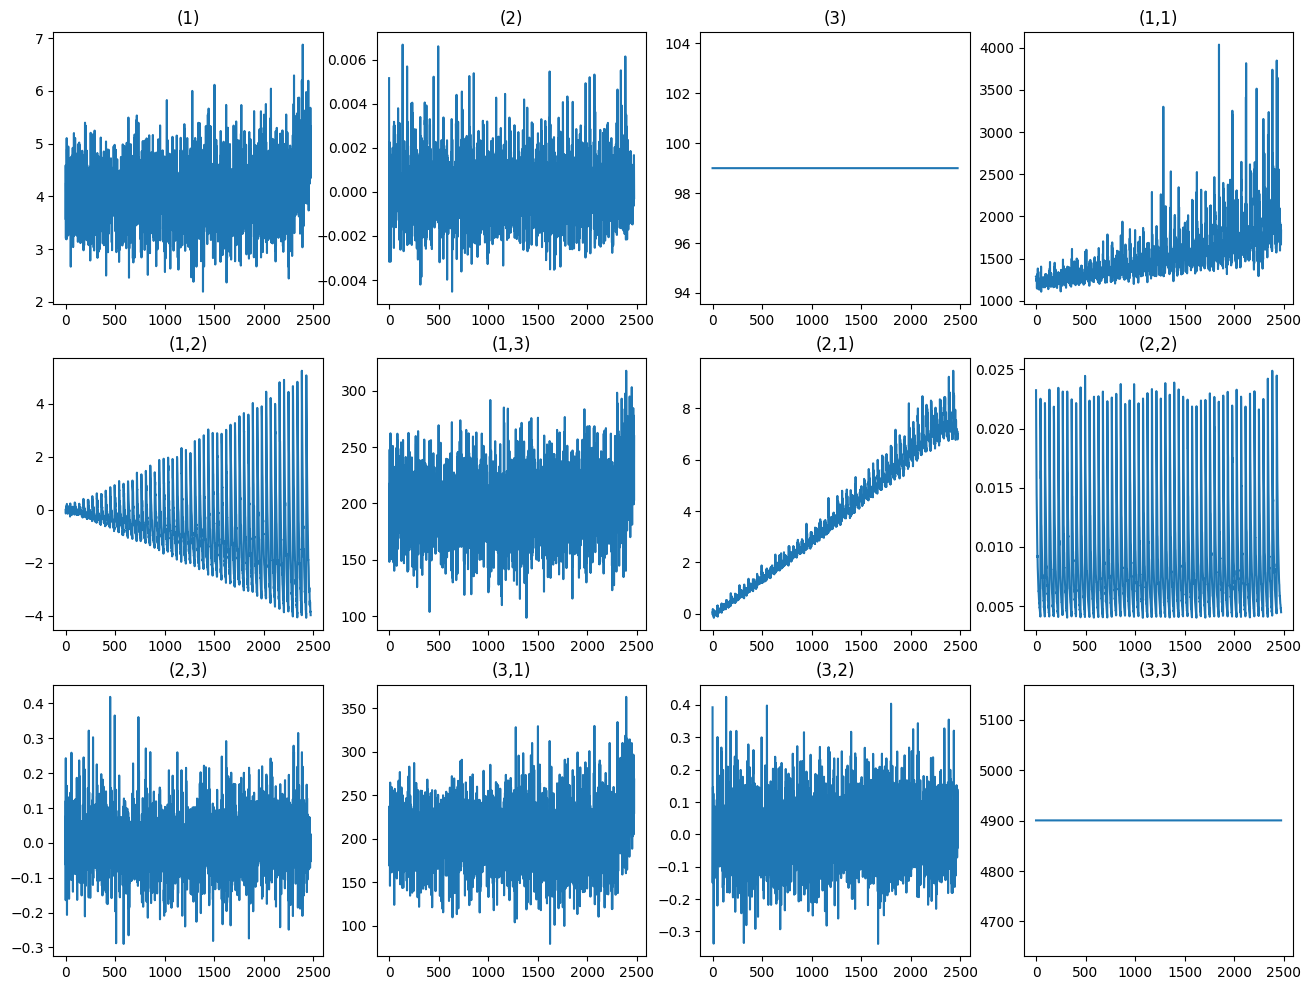

In [65]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_rhos_and_kappas.T[i])

In [66]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in by_parameter_2["by_kappas"]:
              for rho in by_parameter_2["by_rhos"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2475, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2475, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [67]:
results_kappas_and_rhos=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_kappas_and_rhos=results_kappas_and_rhos[0]
Exp_signatures_results_kappas_and_rhos=results_kappas_and_rhos[1]

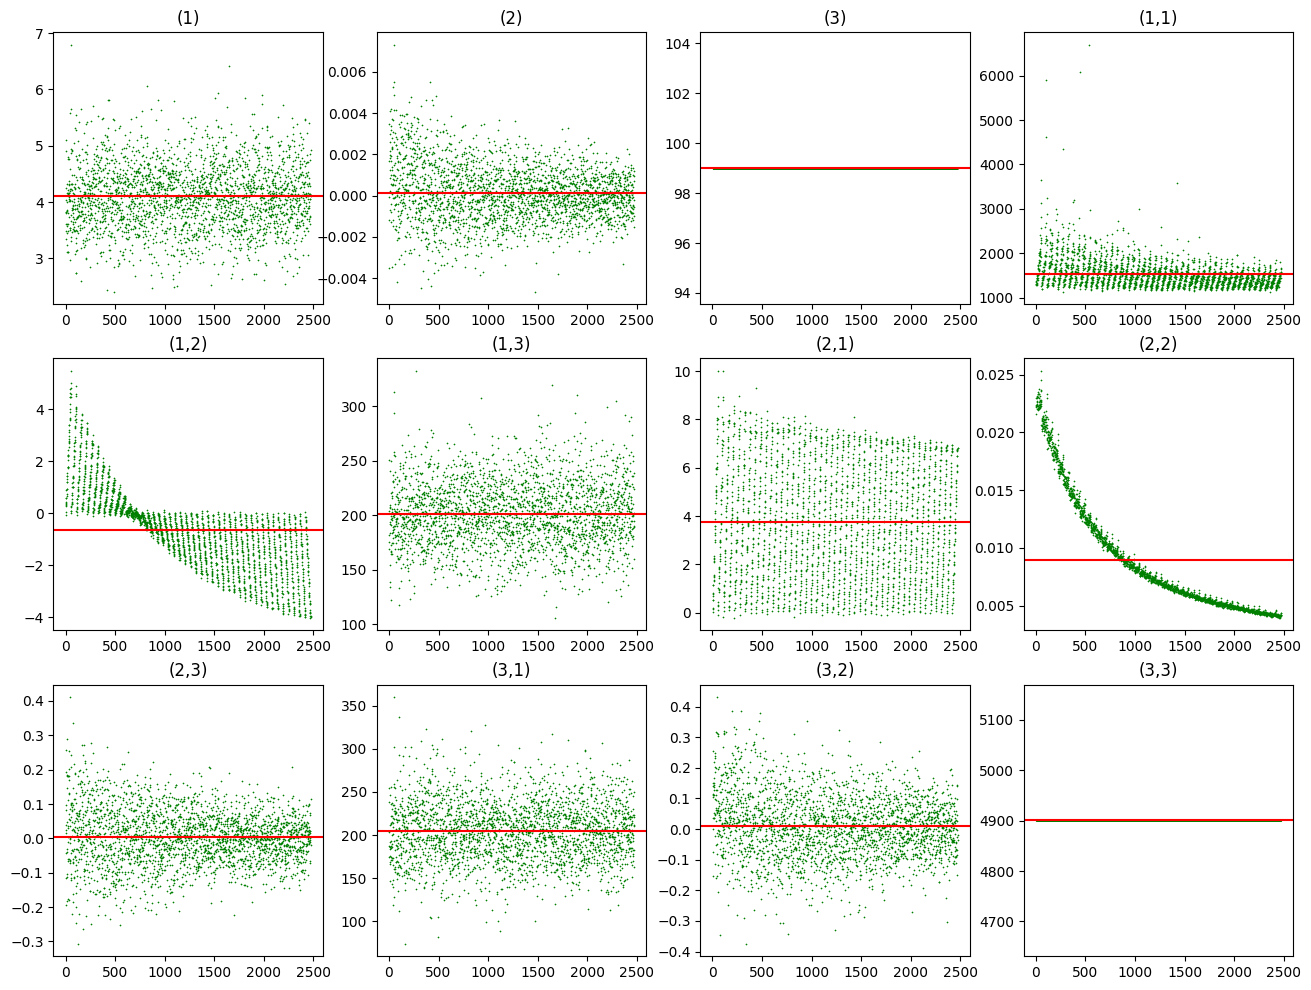

In [68]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2476),Exp_signatures_results_kappas_and_rhos.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas_and_rhos.T[i]), color='red')

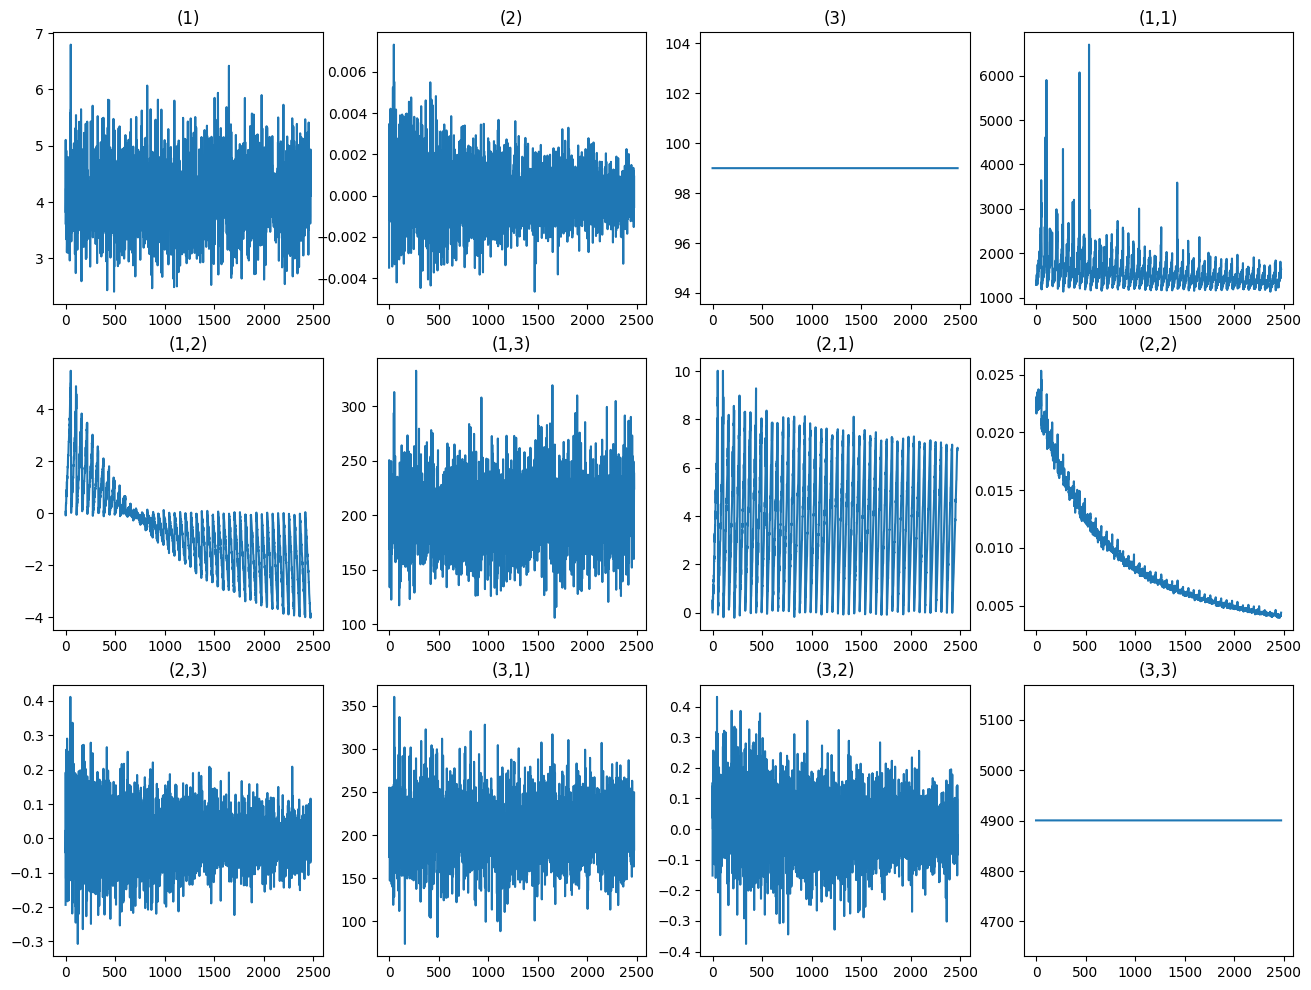

In [69]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas_and_rhos.T[i])